### **Deriving masks using bounding-box annotations**

We are going to make masks for the frames of 13 videos of the Something-Something dataset. These 13 videos can be found on the GitHub page of the Something-Else dataset: https://github.com/joaanna/something_else, together with the bounding-box annotations.

We implemented this code alone, not using external code.

In [ ]:
# Access to dataset through Drive
import os
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
os.chdir('/content/drive/My Drive/')

Mounted at /content/drive/


In [ ]:
%cd '/content/drive/MyDrive/STCN/something_else/'

/content/drive/MyDrive/STCN/something_else


In [ ]:
import json
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
# Open the annotations
with open('annotations.json', 'r') as f:
    annotations = json.load(f)

# Names of the video folders
video_folders = list(annotations.keys())
print('Video folder names : ', video_folders)

Video folder names :  ['151201', '3201', '2003', '44862', '13201', '862', '77005', '22983', '57082', '80962', '2', '4', '6981']


In [ ]:
# Maximum number of colours to use for the masks
max_colours = 0
for video_name in video_folders:
  max_nb_bounding_boxes = 0

  # Maximum number of bounding boxes
  for image in range(len(annotations[video_name])):
    nb_bounding_boxes = len(annotations[video_name][image]['labels'])
    if nb_bounding_boxes > max_nb_bounding_boxes:
      max_nb_bounding_boxes = np.copy(nb_bounding_boxes)

  if max_nb_bounding_boxes > max_colours:
    max_colours = np.copy(max_nb_bounding_boxes)

print('Maximum number of colours to use : ', max_colours)

# Colours : red, yellow, green, blue
colours = [(255, 0, 0), (255, 255, 0), (0, 255, 0), (0, 0, 255)]

Maximum number of colours to use :  4


In [ ]:
# Function for creating bounding boxes
def make_bounding_box(mask, colour, x1, x2, y1, y2):
  r, g, b = colour
  mask[int(y1):int(y2), int(x1):int(x2), 0] = r
  mask[int(y1):int(y2), int(x1):int(x2), 1] = g
  mask[int(y1):int(y2), int(x1):int(x2), 2] = b
  
  return mask

In [ ]:
# Example annotation
# Annotations of the first image in the folder '2'
annotations['2'][0]

{'gt_placeholders': ['pillow'],
 'labels': [{'box2d': {'x1': 97.64950730138266,
    'x2': 427,
    'y1': 11.889318166856967,
    'y2': 239.92858832368972},
   'category': 'pillow',
   'gt_annotation': 'object 0',
   'standard_category': '0000'},
  {'box2d': {'x1': 210.1160330781122,
    'x2': 345.4329005999551,
    'y1': 78.65516045335991,
    'y2': 209.68758889799403},
   'category': 'hand',
   'gt_annotation': 'object hand',
   'standard_category': 'hand'}],
 'name': '2/0001.jpg',
 'nr_instances': 2,
 'split': '80perc_106',
 'task_index': 823,
 'url': 'https://scalabel-something-else.s3-us-west-2.amazonaws.com/annotated_frames/2/0001.jpg'}

Size of the example image :  (240, 427, 3)


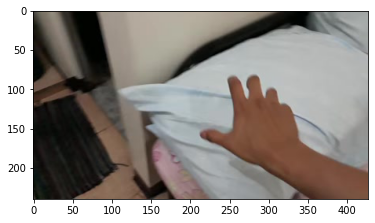

In [ ]:
# Example
# First image in the folder '2'
eg_image_id = annotations['2'][0]['name']    # '2/0001.jpg'
eg_image_path = os.path.join('videos/', eg_image_id)
eg_image = Image.open(eg_image_path)
eg_image = np.array(eg_image, dtype=np.uint8)
print('Size of the example image : ', eg_image.shape)
plt.imshow(eg_image)

In [ ]:
# Properties of the bounding boxes of the example image '2/0001.jpg'
annotations['2'][0]['labels']

[{'box2d': {'x1': 97.64950730138266,
   'x2': 427,
   'y1': 11.889318166856967,
   'y2': 239.92858832368972},
  'category': 'pillow',
  'gt_annotation': 'object 0',
  'standard_category': '0000'},
 {'box2d': {'x1': 210.1160330781122,
   'x2': 345.4329005999551,
   'y1': 78.65516045335991,
   'y2': 209.68758889799403},
  'category': 'hand',
  'gt_annotation': 'object hand',
  'standard_category': 'hand'}]

In [ ]:
# Create a black mask
eg_mask = (eg_image * 0)[:, :, 0]

for colour_id, box in enumerate(annotations['2'][0]['labels']):
  # (0, 0) is the left upper corner of the image
  # (y1, x1) : left upper corner of the box, (y2, x2) : right bottom corner of the box
  x1, x2, y1, y2 = box['box2d']['x1'], box['box2d']['x2'], box['box2d']['y1'], box['box2d']['y2']

  # Create a bounding box
  # eg_mask = make_bounding_box(eg_mask, colours[colour_id], x1, x2, y1, y2)
  eg_mask[int(y1):int(y2), int(x1):int(x2)] = colour_id + 1

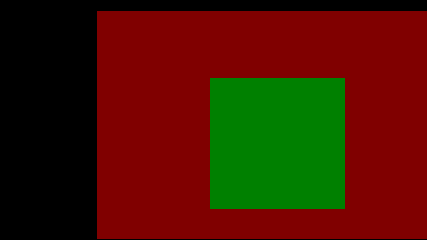

In [ ]:
# Recolour the mask using the palette of the DAVIS 2017 dataset
palette = Image.open('/content/drive/MyDrive/STCN/DAVIS/2017/trainval/Annotations/480p/blackswan/00000.png').getpalette()

eg_mask = Image.fromarray(eg_mask.astype(np.uint8))
eg_mask.putpalette(palette)

# Example mask
eg_mask

## Now we create a mask for every frame in every folder

In [ ]:
# Create a mask for every frame in every folder

palette = Image.open('/content/drive/MyDrive/STCN/DAVIS/2017/trainval/Annotations/480p/blackswan/00000.png').getpalette()
path3 = '/content/drive/MyDrive/STCN/Something480p/Annotations/480p'

for video_name in video_folders:    # Iterations over all the video folders

  for frame_id in range(len(annotations[video_name])):    # Iterations over all the frames in one folder
    image_id = annotations[video_name][frame_id]['name']    # '2/0001.jpg' for example
    image_path = os.path.join('videos/', image_id)
    image = Image.open(image_path)
    image = np.array(image, dtype=np.uint8)
    mask = (image * 0)[:, :, 0]

    # Create the bounding boxes
    for colour_id, box in enumerate(annotations[video_name][frame_id]['labels']):
      x1, x2, y1, y2 = box['box2d']['x1'], box['box2d']['x2'], box['box2d']['y1'], box['box2d']['y2']
      mask[int(y1):int(y2), int(x1):int(x2)] = colour_id + 1
    
    if not os.path.isdir(os.path.join(path3, video_name)):
      os.makedirs(os.path.join(path3, video_name))

    # Save mask
    image = Image.fromarray(mask.astype(np.uint8))
    image.putpalette(palette)                          # Recolour
    width, height = image.size
    newsize = ((int(480 * width / height), 480))       # Resize
    image = image.resize(newsize)
    image_id = int(image_id[:-4].split('/')[1]) - 1    # Rename
    image_id = f'{image_id:05d}.png'
    image.save(os.path.join(path3, video_name, image_id))

In [ ]:
# Checking if there is as many annotation frames as jpg images
path2 = '/content/drive/MyDrive/STCN/Something480p/JPEGImages/480p'
path3 = '/content/drive/MyDrive/STCN/Something480p/Annotations/480p'

print('Video names |', 'Number of jpg images |', 'Number of masks')
for video_name in video_folders:
  print(video_name, len(os.listdir(os.path.join(path2, video_name))), len(os.listdir(os.path.join(path3, video_name))))

Video names | Number of jpg images | Number of masks
151201 23 23
3201 43 43
2003 43 43
44862 46 46
13201 49 49
862 47 47
77005 43 43
22983 52 52
57082 38 38
80962 58 58
2 48 48
4 42 42
6981 23 23
